In [1116]:
import torch, torchvision
import pandas as pd


In [ ]:
# Transformation Pipeline

transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert("RGB")),
    torchvision.transforms.RandomRotation((0,360)),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomPerspective(distortion_scale=0.5,p=0.3),
    torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [1118]:
dataset = torchvision.datasets.ImageFolder('./dataset',transform=transform)

In [1119]:
# test_size = 0.2 * len(dataset)
# test_set = torch.utils.data.Subset(dataset,range(int(test_size)))
# train_set = torch.utils.data.Subset(dataset,range(int(test_size),len(dataset)))

In [1120]:
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

# Perform the random split
# We add a generator for reproducibility
generator = torch.Generator().manual_seed(42)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=generator)


In [1121]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle= False)

In [1122]:
dataset.classes

['paper', 'rock', 'scissors']

In [1123]:
len(test_set)

1981

In [1124]:
len(train_set)

7924

In [1125]:
img,label = train_set[4]

In [1126]:
img

tensor([[[-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         ...,
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804]],

        [[-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         ...,
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804]],

        [[-0.7804, -0.7804, -0.7804,  ..., -0.7804, -0.7804, -0.7804],
         [-0.7804, -0.7804, -0.7804,  ..., -0

In [1127]:
label

1

In [1128]:
img.size()

torch.Size([3, 128, 128])

In [1129]:
class_names = dataset.classes
class_names

['paper', 'rock', 'scissors']

## CNN Model

In [1130]:
import torch.nn as nn
from torch.nn import MaxPool2d,Conv2d,Linear,Dropout,BatchNorm2d
import torch.nn.functional as F

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1: 3 input channels, 16 output channels, 3x3 kernel

        self.conv1 = Conv2d(3, 16, 3)
        self.bn1 = BatchNorm2d(16)
        self.pool1 = MaxPool2d(2, 2) # -> Output: (16, 63, 63)

        # Layer 2: 16 input channels, 32 output channels, 4x4 kernel
        
        self.conv2 = Conv2d(16, 32, 4)
        self.bn2 = BatchNorm2d(32)
        self.pool2 = MaxPool2d(4, 4) # -> Output: (32, 15, 15)

        # Flattening will make it (32 * 15 * 15) = 7200
        
        # Fully connected layers
        self.fc1 = Linear(7200, 128)
        self.dropout1 = Dropout(p=0.5)
        
        self.fc2 = Linear(128, 64)
        self.dropout2 = Dropout(p=0.5)

        self.fc3 = Linear(64, 32)
        self.dropout3 = Dropout(p=0.5)

        self.fc4 = Linear(32, 10)
        self.dropout4 = Dropout(p=0.5)

        self.fc5 = Linear(10, 3) # Final output layer for 3 classes

    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten the output for the linear layers
        x = torch.flatten(x, 1)
        
        # Fully connected blocks with ReLU and Dropout
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.dropout3(F.relu(self.fc3(x)))
        x = self.dropout4(F.relu(self.fc4(x)))
        
        # Output layer (no activation, as CrossEntropyLoss expects raw logits)
        x = self.fc5(x)
        return x

In [1132]:

model = NeuralNet()

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.AdamW(model.parameters(),lr=0.0001,weight_decay=0.001)



In [1155]:
for epoch in range(50): # Increased epochs
    model.train() # Set model to training mode
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

    # --- VALIDATION STEP ---
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Val Accuracy: {val_accuracy:.2f}%')
    




Epoch 1 | Loss: 0.5367 | Val Accuracy: 89.70%
Epoch 2 | Loss: 0.4834 | Val Accuracy: 93.03%
Epoch 3 | Loss: 0.4987 | Val Accuracy: 89.00%
Epoch 4 | Loss: 0.4846 | Val Accuracy: 92.23%
Epoch 5 | Loss: 0.4946 | Val Accuracy: 92.18%
Epoch 6 | Loss: 0.5043 | Val Accuracy: 94.09%
Epoch 7 | Loss: 0.4913 | Val Accuracy: 92.88%
Epoch 8 | Loss: 0.5016 | Val Accuracy: 92.13%
Epoch 9 | Loss: 0.5042 | Val Accuracy: 93.34%
Epoch 10 | Loss: 0.4996 | Val Accuracy: 90.61%
Epoch 11 | Loss: 0.5167 | Val Accuracy: 91.72%
Epoch 12 | Loss: 0.5452 | Val Accuracy: 81.17%
Epoch 13 | Loss: 0.5300 | Val Accuracy: 91.87%
Epoch 14 | Loss: 0.5212 | Val Accuracy: 92.88%
Epoch 15 | Loss: 0.5042 | Val Accuracy: 92.88%
Epoch 16 | Loss: 0.4769 | Val Accuracy: 92.83%
Epoch 17 | Loss: 0.5867 | Val Accuracy: 93.39%
Epoch 18 | Loss: 0.5054 | Val Accuracy: 85.06%
Epoch 19 | Loss: 0.5092 | Val Accuracy: 92.88%
Epoch 20 | Loss: 0.4946 | Val Accuracy: 92.18%
Epoch 21 | Loss: 0.4991 | Val Accuracy: 93.54%
Epoch 22 | Loss: 0.488

In [1156]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images,labels = data
        outputs = model(images)
        _,predicted = torch.max(outputs,1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct/total *100

print(f'Accuracy: {accuracy}')
        

Accuracy: 92.73094396769308


In [1157]:
from PIL import Image

In [1158]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert("RGB")),
    torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    
])

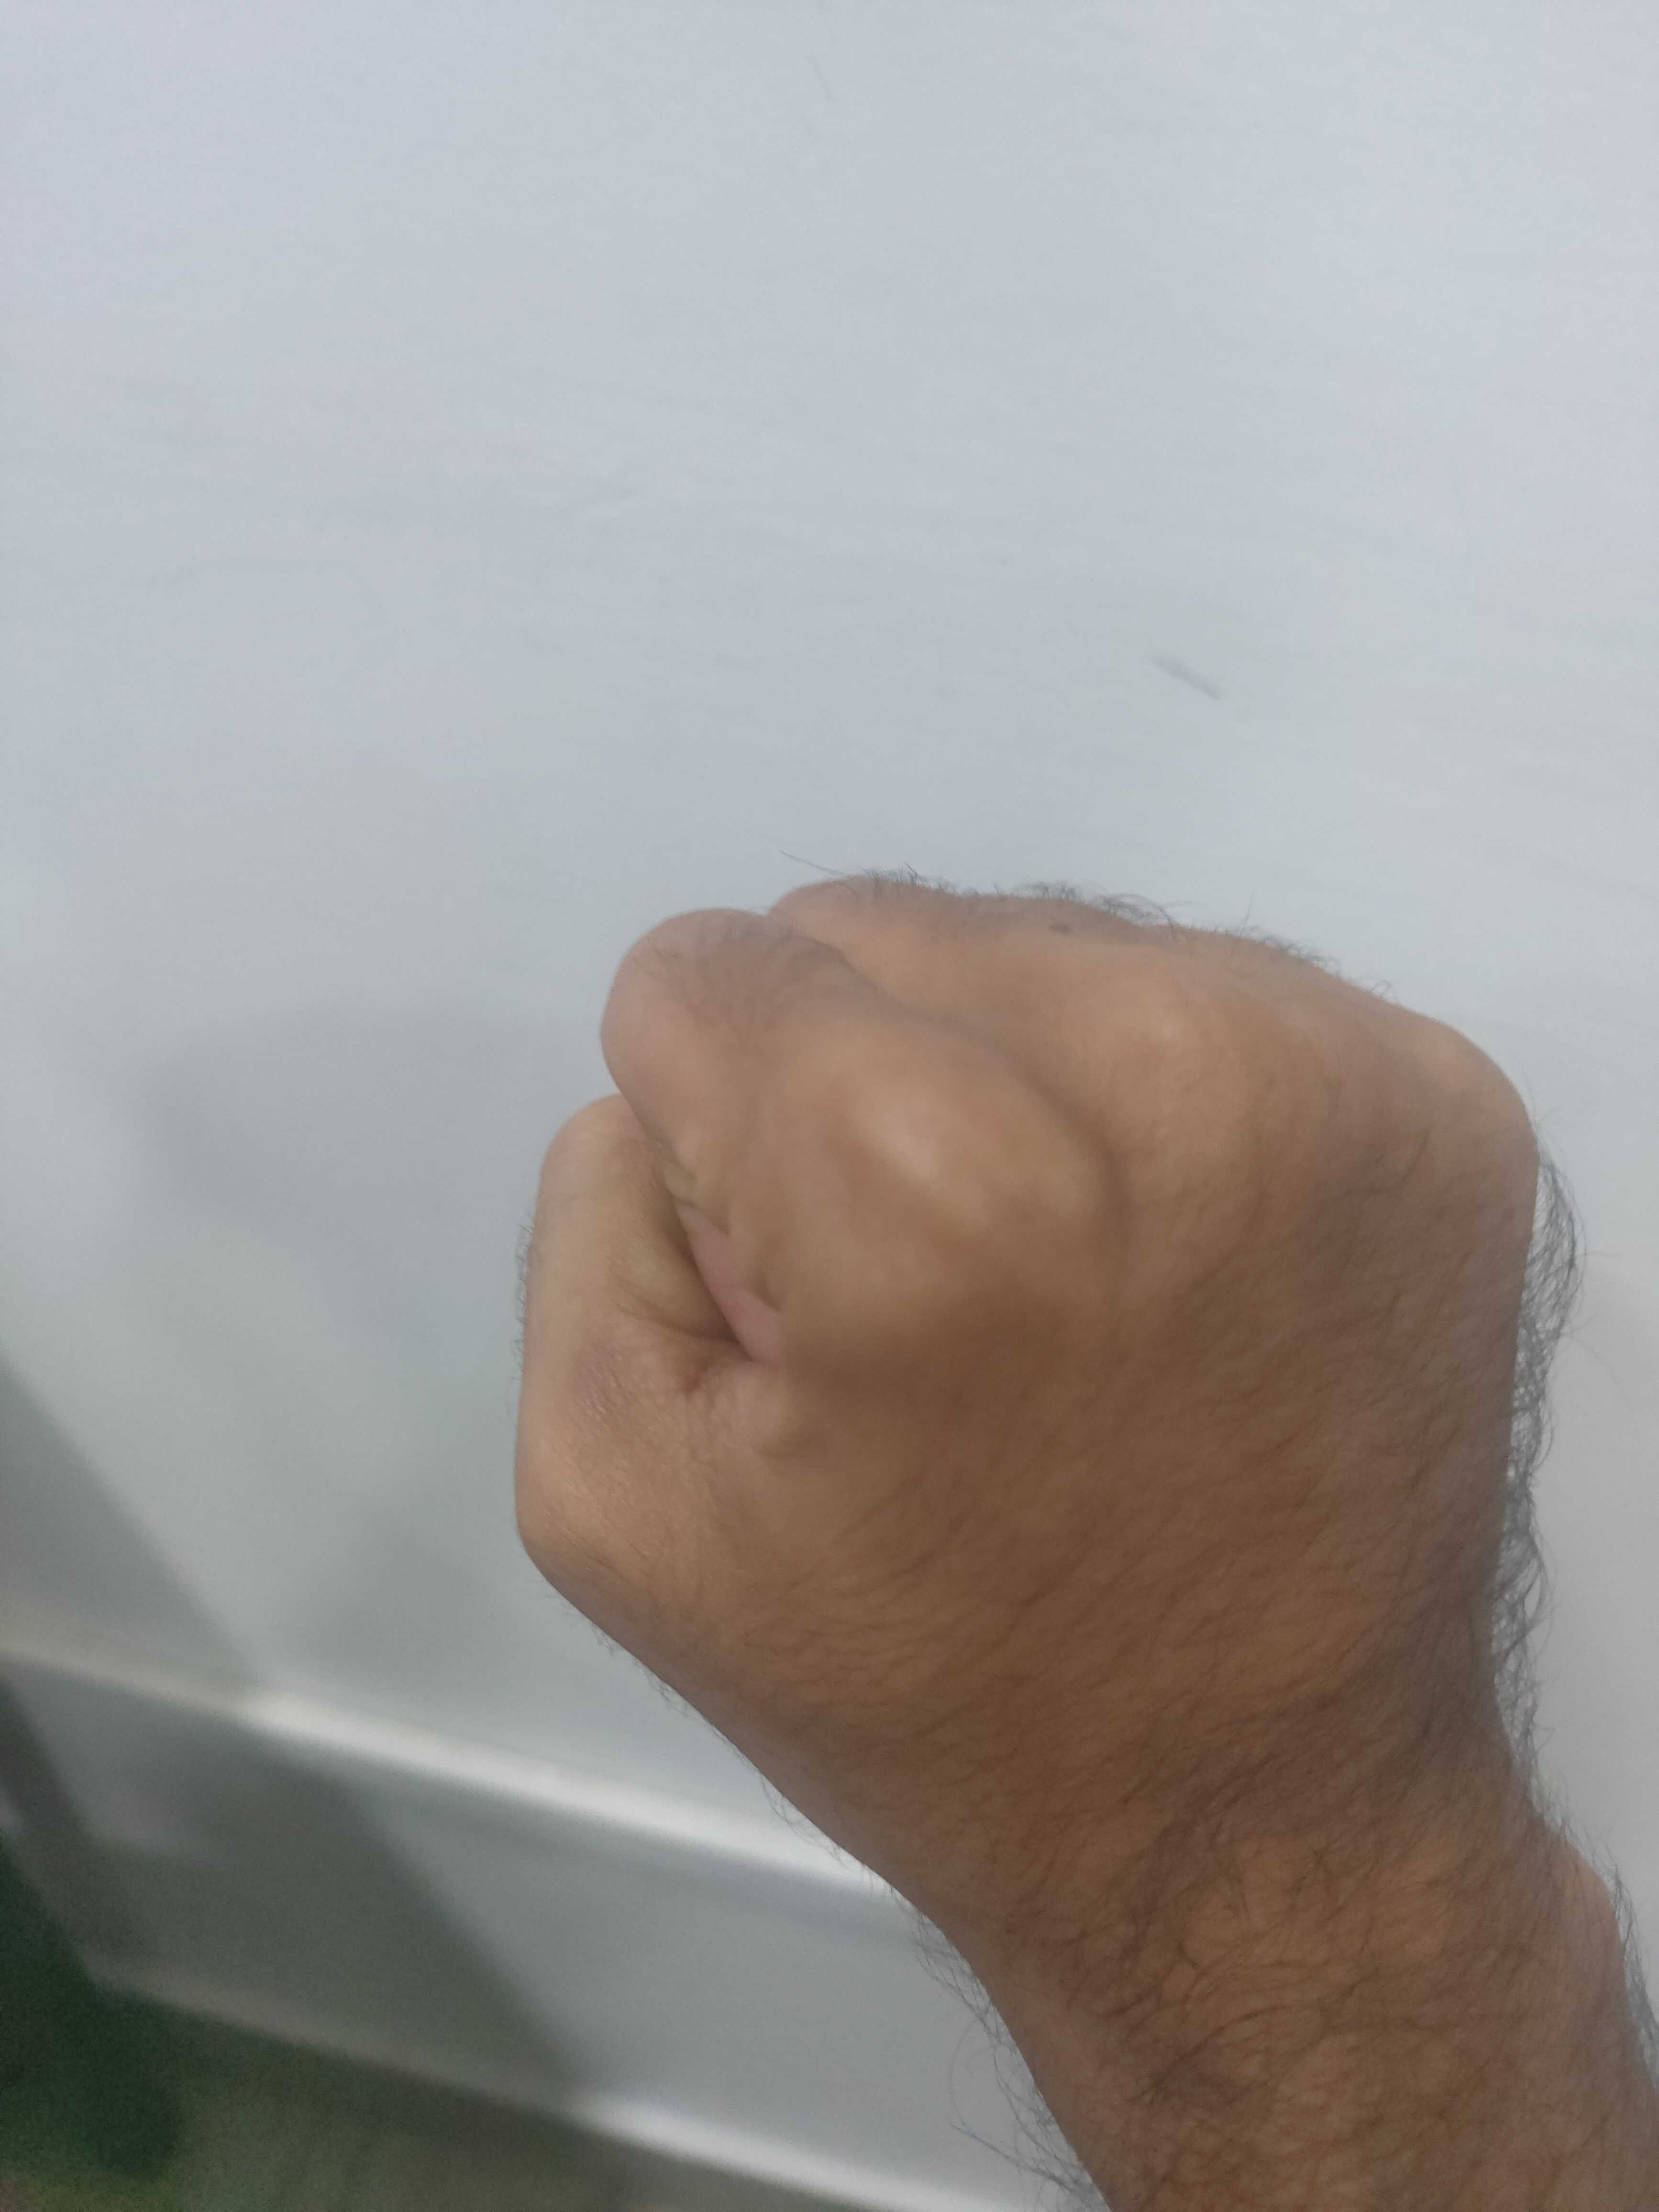

In [1166]:
def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)

    return image

image_path = './data_rps_test_2/IMG_20250918_104228.jpg'

img = Image.open(image_path)
img


In [1160]:
import matplotlib.pyplot as plt

In [1140]:
# torch.save(model.state_dict(),'model_last.pth')

In [1162]:
new_model = NeuralNet()

new_model.load_state_dict(torch.load('model_last.pth'))

<All keys matched successfully>

## Model Prediction

In [1163]:
correct = 0
total = 0

new_model.eval()

with torch.no_grad():
  for data in test_loader:
    images,labels = data
    outputs = new_model(images)
    _ ,predicted = torch.max(outputs,1)
    total+=labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total

print(f'Accuracy : {accuracy}')

Accuracy : 92.37758707723373


In [1167]:
import os

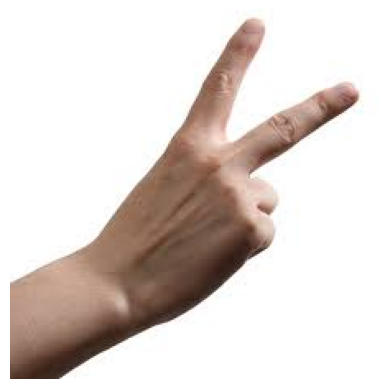

./data_rps_test 2/sample1.jpeg
2
scissors


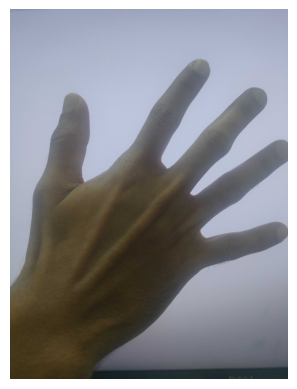

./data_rps_test 2/IMG_20250918_104834.jpg
0
paper


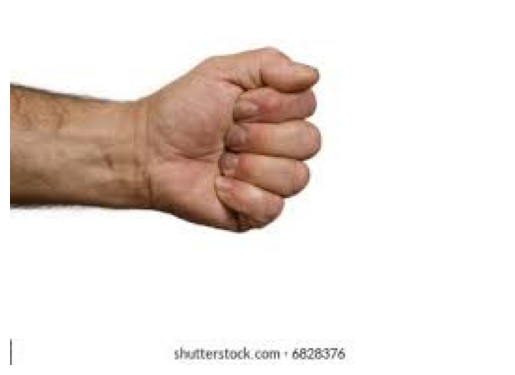

./data_rps_test 2/images.jpeg
1
rock


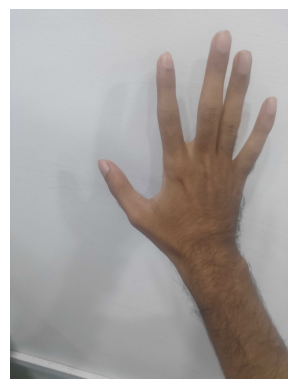

./data_rps_test 2/IMG_20250918_104202.jpg
0
paper


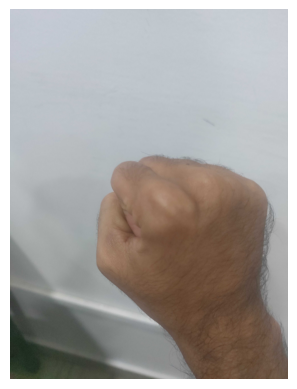

./data_rps_test 2/IMG_20250918_104228.jpg
1
rock


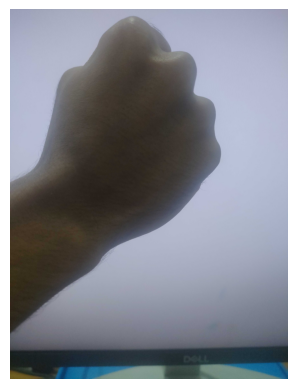

./data_rps_test 2/IMG_20250918_104822.jpg
1
rock


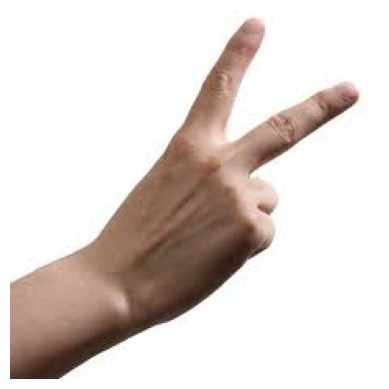

./data_rps_test 2/images (1).jpeg
2
scissors


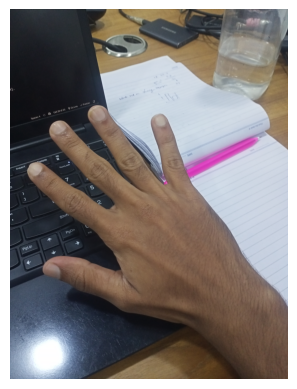

./data_rps_test 2/IMG20250918120950.jpg
0
paper


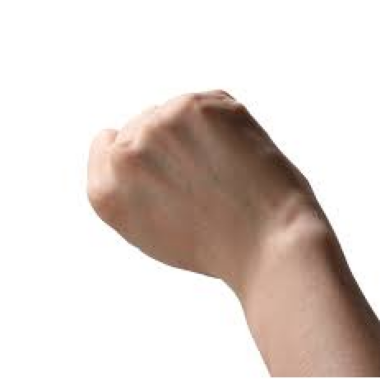

./data_rps_test 2/images (3).jpeg
1
rock


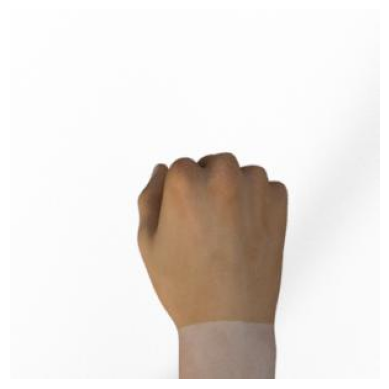

./data_rps_test 2/original.jpg
1
rock


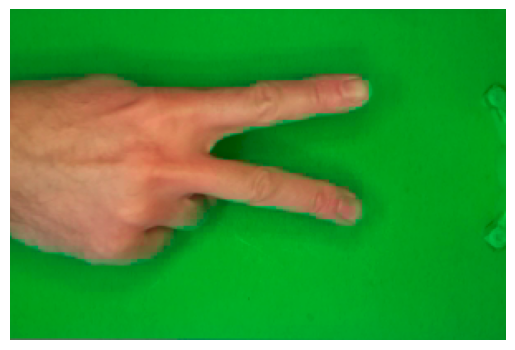

./data_rps_test 2/0Flw60Z2MAWWKn6S.png
2
scissors


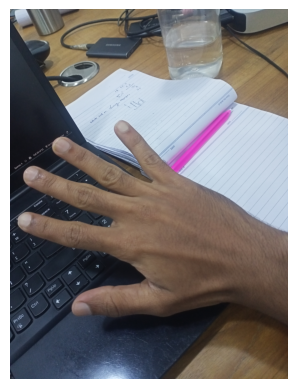

./data_rps_test 2/IMG20250918120947.jpg
0
paper


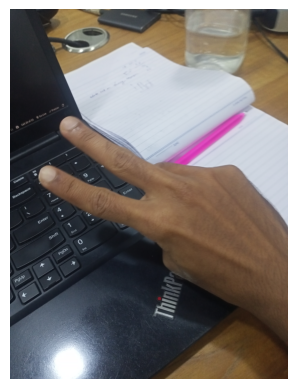

./data_rps_test 2/IMG20250918120953.jpg
2
scissors


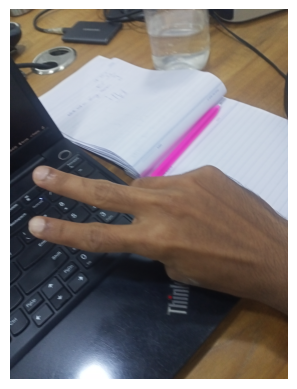

./data_rps_test 2/IMG20250918120957.jpg
2
scissors


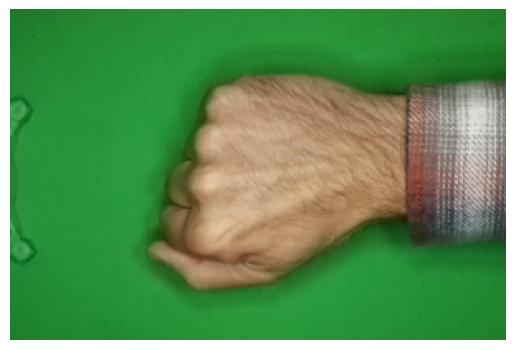

./data_rps_test 2/01dM3ewPIsnBICu1.png
1
rock


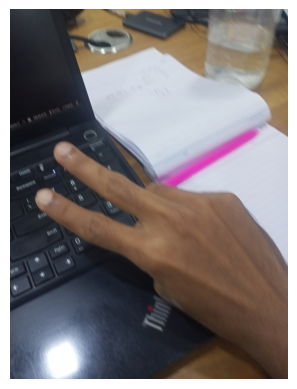

./data_rps_test 2/IMG20250918120958.jpg
2
scissors


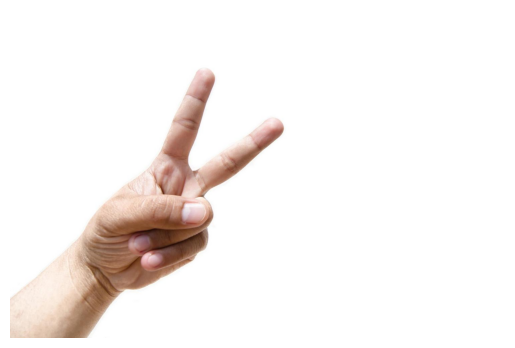

./data_rps_test 2/scissors-gesture-on-left-hand-for-concept-of-rock-paper-scissors-game-isolated-on-white-background-free-photo.jpeg
0
paper


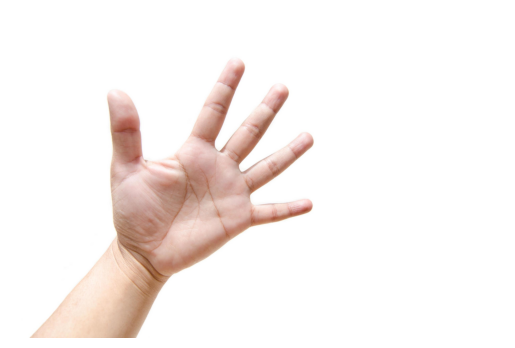

./data_rps_test 2/palm.jpeg
0
paper


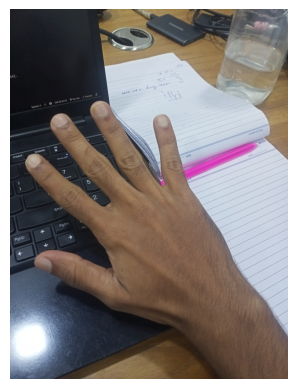

./data_rps_test 2/IMG20250918120949.jpg
0
paper


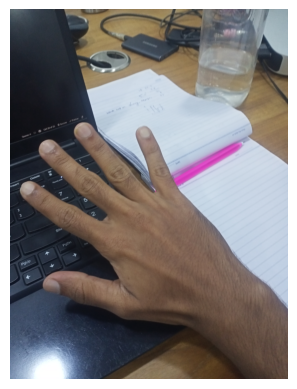

./data_rps_test 2/IMG20250918120948.jpg
0
paper


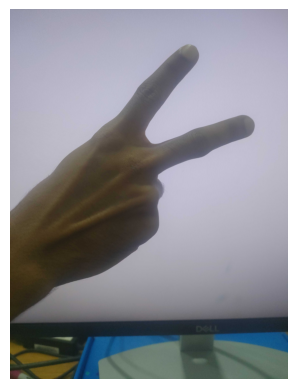

./data_rps_test 2/IMG_20250918_104807.jpg
2
scissors


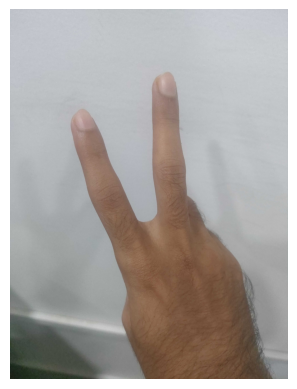

./data_rps_test 2/IMG_20250918_104236.jpg
0
paper


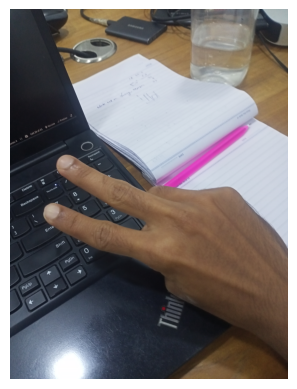

./data_rps_test 2/IMG20250918120957 (1).jpg
2
scissors


In [ ]:
for i in os.listdir('./data_rps_test_2'):
    image_path = './data_rps_test_2/' + i
    if not i.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
        continue
    plt.imshow(plt.imread(image_path))
    
    plt.axis('off')
    plt.show()
    
    img = load_image(image_path)
    print(image_path)
    with torch.no_grad():
        output = new_model(img)
        
        _,predicted = torch.max(output,1)
        
        print(predicted.item())
        print(class_names[predicted.item()])